#  Animal Recognition Using TensorFlow
Chung-Yang Li, li.chun@husky.neu.edu

Zixuan Yu, yu.zix@husky.neu.edu   

<img src="1.jpg" alt="GitHub" title="GitHub,Social Coding" width="1000" height="1000">


### Abstract

Animal recognition is a computer technology using machine learning and TensorFlow. This project aims to recognize various animals by applying machine learning and TensorFlow into the real world. By giving sufficient number of datasets, we can train our classified model and further accurately recognize various animals (six species). There are several types of models for CNN, we have test numerous hyper-parameter to reach best performance. These hyper-parameters are important; iteration, learning rate and activation functions, which affect speed and accuracy. In our training process, we only use 600 images (6 species, each species has 100) and could reach approximately 50% accuracy score. We believe that if we have enough training images, our model will come out with a great performance. 

### BackGround
In our project, we introduce useful deep learning library called Keras and Tensorflow. Keras is an user friendly high level neural network API, which runs on top of Tensorflow. Tensorflow is the most popular library used for training deep learning model. These two machine learning libraries are based on deep learning neural network, they have powerful performance on training model and reading datasets. Therefore, we decide to implement these two helpful tools into our project. 

### Approach
Method:Convolution Neural Network(CNNS)


We implement Convolution Neural Network to classify animal images.

<table><tr><td bgcolor=orange>
Running Python in Jupyter Notebook
Python is an interpreted high-level programming language for general-purpose programming.
To install Python and get tutorials, pelase visit their _[OFFICIAL SITE](https://www.python.org/)_
Or you can also browse the tutorial site _[Lynda.com](https://lynda.com/), they have many fabulous crouses on the site

__Jupyter Notebook__ is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. It is the most popular tool to run Python on.
To have jupyter notebook up and run, please install the IDE Anaconda first.
Or refer to https://github.com/nikbearbrown/INFO_7390/blob/master/Week_1/NBB_Intro_Python.ipynb
</td></tr></table>

<div class="alert alert-block alert-info">** Before running the code, please install "tensorflow_base","tqdm","tensorflow" module through pip. <br>
You can simple do it by typping "pip install "tensorflow_base","pip install tqdm", "pip install tensorflow" in the Anaconda Prompt, or we recommend that using the Environments in the Anaconda navigator is much easier. <br>
We also recommend to exploit GPU to run this code, please refer to tensorflow official website: https://www.tensorflow.org/guide/using_gpu**</div>

<img src="2.png" alt="GitHub" title="GitHub,Social Coding" width="1000" height="1000">

### Convolutional Neural Networks (CNNs / ConvNets)

Convolutional Neural Networks are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other, and it has loss function (SVM/Softmax) on the last  layer(fully-connected layer).

ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture, which makes the forward function more efficient to implement and reduce the amount of parameters in the network.

We use 3 main types of layers to build convolution network architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer . We stack these layers to form a full convolution network architecture.

INPUT 128x128x3 hold the raw pixel values of the image, in our case image of width 128, height 128, and with three color channels R,G,B.

CONV layer compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This result in volume 128x128x32 based on we decide to use 32 filters(num_filters_conv = 32).

RELU layer apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged.

POOL layer perform a downsampling operation along the spatial dimensions (width, height).

FC (fully-connected) layer compute the class scores, resulting in volume of size 1x1x6, where each of the 6 numbers correspond to a class score. As with ordinary Neural Networks, each neuron in this layer will be connected to all the numbers in the previous volume.

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

<h3>Load</h3>

#### Here we define load_train, next_batch, read_train_sets methods for further use 

#### load_train: this function is main method to load training data from the file.

In [2]:
import cv2
import os
import glob
from sklearn.utils import shuffle
import numpy as np


def load_train(train_path, image_size, classes):
    images = []
    labels = []
    img_names = []
    cls = []

    print('Going to read training images')
    for fields in classes:   
        index = classes.index(fields)
        print('Now going to read {} files (Index: {})'.format(fields, index))
        path = os.path.join(train_path, fields, '*g')
        files = glob.glob(path)
        for fl in files:
            try:
                image = cv2.imread(fl)
                image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            except:
                print(image)
            image = image.astype(np.float32)
            image = np.multiply(image, 1.0 / 255.0)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            img_names.append(flbase)
            cls.append(fields)
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)

    return images, labels, img_names, cls


class DataSet(object):

  def __init__(self, images, labels, img_names, cls):
    self._num_examples = images.shape[0]

    self._images = images
    self._labels = labels
    self._img_names = img_names
    self._cls = cls
    self._epochs_done = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def img_names(self):
    return self._img_names

  @property
  def cls(self):
    return self._cls

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_done(self):
    return self._epochs_done

  def next_batch(self, batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    self._index_in_epoch += batch_size

    if self._index_in_epoch > self._num_examples:
      # After each epoch we update this
      self._epochs_done += 1
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch

    return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size):
  class DataSets(object):
    pass
  data_sets = DataSets()

  images, labels, img_names, cls = load_train(train_path, image_size, classes)
  images, labels, img_names, cls = shuffle(images, labels, img_names, cls)  

  if isinstance(validation_size, float):
    validation_size = int(validation_size * images.shape[0])

  validation_images = images[:validation_size]
  validation_labels = labels[:validation_size]
  validation_img_names = img_names[:validation_size]
  validation_cls = cls[:validation_size]

  train_images = images[validation_size:]
  train_labels = labels[validation_size:]
  train_img_names = img_names[validation_size:]
  train_cls = cls[validation_size:]

  data_sets.train = DataSet(train_images, train_labels, train_img_names, train_cls)
  data_sets.valid = DataSet(validation_images, validation_labels, validation_img_names, validation_cls)

  return data_sets

In [3]:
import tensorflow as tf
import time
from datetime import timedelta
import math
import random
import numpy as np
import os

#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


batch_size = 10

#Prepare input data
classes = os.listdir('../Data/Train')
num_classes = len(classes)

# 20% of the data will automatically be used for validation
validation_size = 0.2
img_size = 128
num_channels = 3
train_path='../Data/Train'

# We shall load all the training and validation images and labels into memory using openCV and use that during training
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t{}".format(len(data.train.labels)))
print("Number of files in Validation-set:\t{}".format(len(data.valid.labels)))

Going to read training images
Now going to read Bird files (Index: 0)
Now going to read Cat files (Index: 1)
Now going to read Dog files (Index: 2)
Now going to read Horse files (Index: 3)
Now going to read Lion files (Index: 4)
Now going to read Monkey files (Index: 5)
Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:	480
Number of files in Validation-set:	120


#### Here we read 600 animal images, 480 for traning and 120 for validation.

#### After we successfully load 6 classes of imaeges, we start defining our Convolution Neural Network

In [4]:
session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

## labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)



##Network graph params
filter_size_conv1 = 3 
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64
  
fc_layer_size = 32

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))



def create_convolutional_layer(input,
               num_input_channels, 
               conv_filter_size,        
               num_filters):  
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)
    
    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.selu(layer)

    return layer



def create_flatten_layer(layer):
    #We know that the shape of the layer will be [batch_size img_size img_size num_channels] 
    # But let's get it from the previous layer.
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width* num_channels. But we shall calculate it in place of hard-coding it.
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input,          
             num_inputs,    
             num_outputs,
             use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.selu(layer)

    return layer

### Full scope of our model:

<img src="3.png" alt="GitHub" title="GitHub,Social Coding" width="1000" height="1000">

The image below is the sample of the pooling layer. The polling layer operates independently on each depth slice entered and spatially resizes it. The most common form is a pooling layer with a 2×2 size filter that applies 2 down sampled steps along the width and height at each depth slice in the input, discarding 75% of the activation. In this case, each maximum operation exceeds 4 digits. The depth dimension remains the same.

<img src="4.png" alt="GitHub" title="GitHub,Social Coding" width="500" height="500">

#### We define weights and biases for our convolution layer and using max pooling method(tf.nn.max_pool) and zero padding(padding='SAME')

#### For our model, we decide to use activation function(tf.nn.selu)

#### At here we create convolution layer, flatten layer and fully connected layer

In [5]:
layer_conv1 = create_convolutional_layer(input=x,
               num_input_channels=num_channels,
               conv_filter_size=filter_size_conv1,
               num_filters=num_filters_conv1)
layer_conv2 = create_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2,
               num_filters=num_filters_conv2)

layer_conv3= create_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters_conv2,
               conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)
          
layer_flat = create_flatten_layer(layer_conv3)

layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_layer_size,
                     use_relu=True)

layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_layer_size,
                     num_outputs=num_classes,
                     use_relu=False) 

y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, axis=1)
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)
# optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
# optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost,global_step=tf.train.create_global_step())
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


session.run(tf.global_variables_initializer()) 

<h3>Train</h3>

#### Here we start training our model and use (tf.train.saver) to save our model for future use

In [6]:
def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

total_iterations = 0

saver = tf.train.Saver(write_version=tf.train.SaverDef.V1)

def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations,
                   total_iterations + num_iteration):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)

        
        feed_dict_tr = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_val = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_tr)

        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_val)
            epoch = int(i / int(data.train.num_examples/batch_size))    
            
            show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
#             saver.save(session, 'D:\download\Animals\Model\Animals_model')
#             saver.save(session, 'D:\download\Animals\Model\Animals_model.ckpt', global_step = session.run(tf.train.get_global_step()))
            saver_path = saver.save(session, "../Data/Model/Animals_model.ckpt")
            print("Model saved in file:", saver_path)

    total_iterations += num_iteration

# train(num_iteration=3000)
# train(num_iteration=1750)
train(num_iteration=1250)

Training Epoch 1 --- Training Accuracy:  40.0%, Validation Accuracy:  30.0%,  Validation Loss: 1.723
Model saved in file: ../Data/Model/Animals_model.ckpt
Training Epoch 2 --- Training Accuracy:  40.0%, Validation Accuracy:   0.0%,  Validation Loss: 1.876
Model saved in file: ../Data/Model/Animals_model.ckpt
Training Epoch 3 --- Training Accuracy:  50.0%, Validation Accuracy:  20.0%,  Validation Loss: 1.586
Model saved in file: ../Data/Model/Animals_model.ckpt
Training Epoch 4 --- Training Accuracy:  50.0%, Validation Accuracy:  20.0%,  Validation Loss: 1.521
Model saved in file: ../Data/Model/Animals_model.ckpt
Training Epoch 5 --- Training Accuracy:  70.0%, Validation Accuracy:  30.0%,  Validation Loss: 1.504
Model saved in file: ../Data/Model/Animals_model.ckpt
Training Epoch 6 --- Training Accuracy: 100.0%, Validation Accuracy:  40.0%,  Validation Loss: 1.518
Model saved in file: ../Data/Model/Animals_model.ckpt
Training Epoch 7 --- Training Accuracy: 100.0%, Validation Accuracy:  

<h3>Predict</h3>

#### After we successfully train our model, we can make a prediction of images in Test file(15 for each type of animals).

#### At the end label with predicted animal type and print accuracy of indicidual prediction and total prediction

#### We use (saver.restore) to restore our model which have been saved in destination file

Now going to read Bird files (Index: 0)
accuracy: 0.4666666666666667
Now going to read Cat files (Index: 1)
accuracy: 0.6
Now going to read Dog files (Index: 2)
accuracy: 0.6
Now going to read Horse files (Index: 3)
accuracy: 0.5333333333333333
Now going to read Lion files (Index: 4)
accuracy: 0.6
Now going to read Monkey files (Index: 5)
accuracy: 0.26666666666666666
total accuracy:  0.5111111111111111


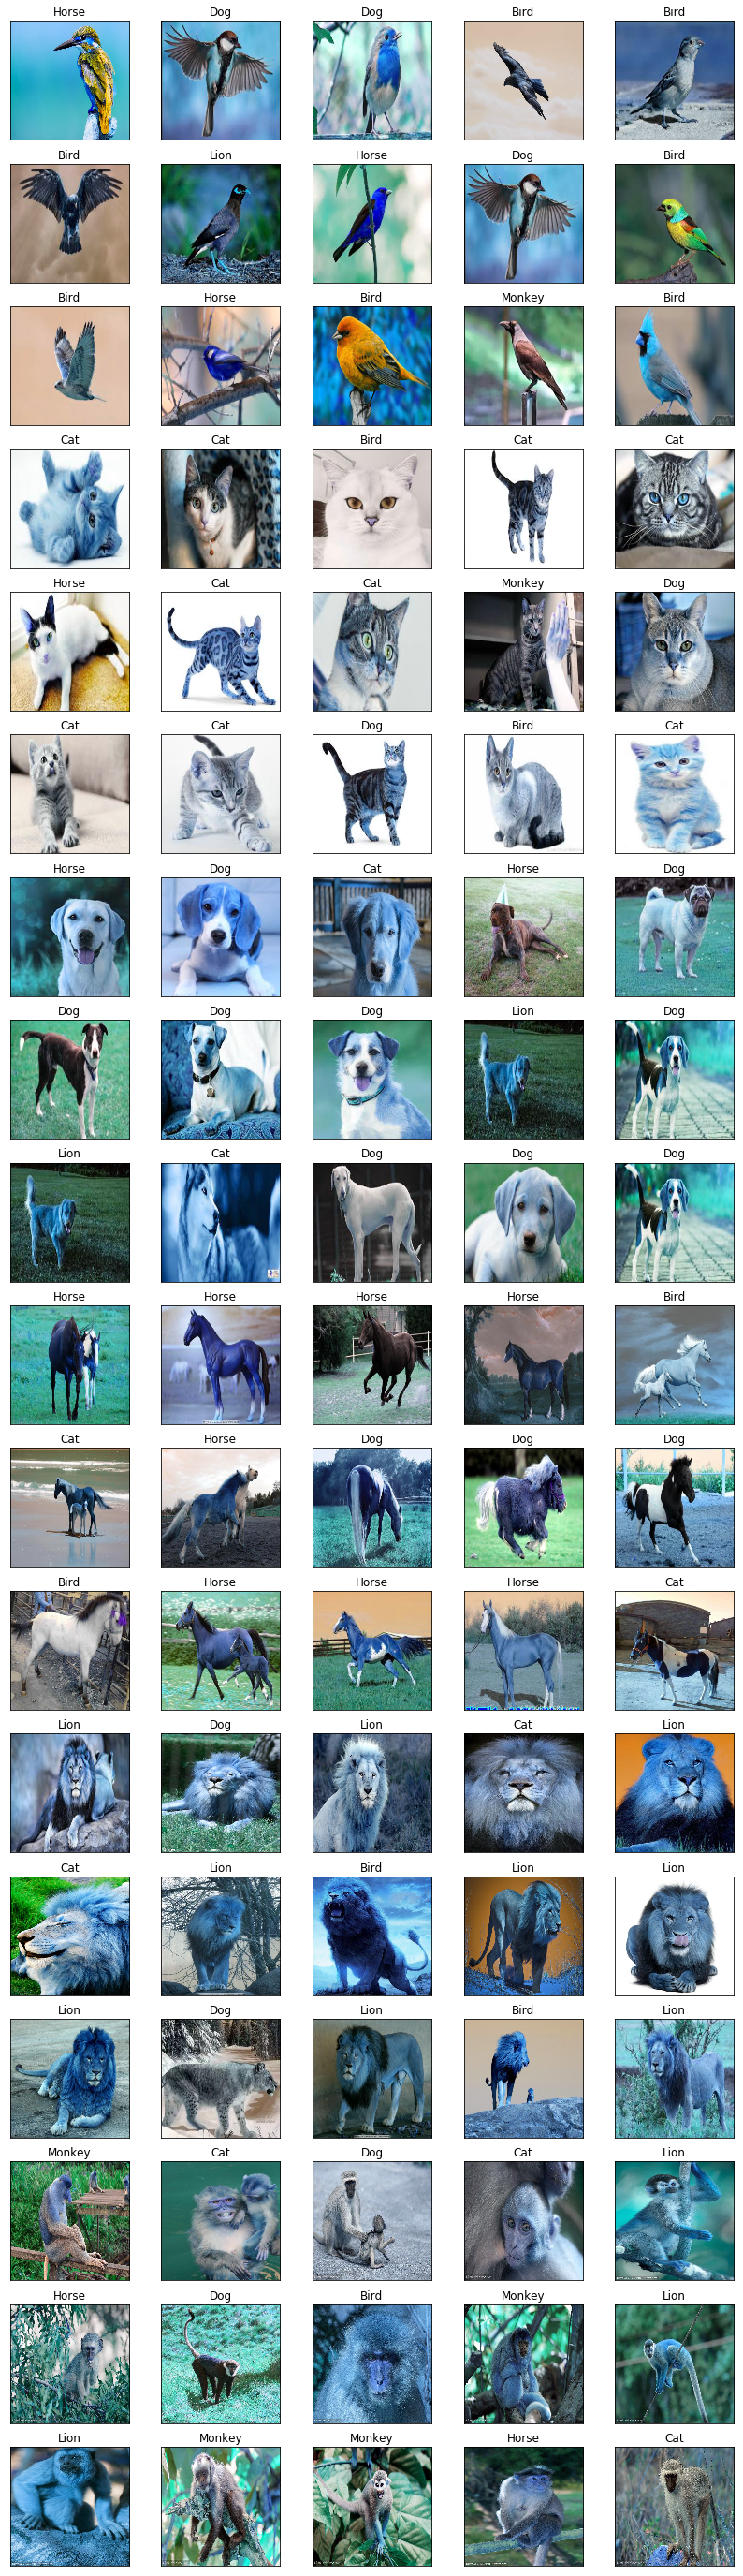

In [8]:
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import os,glob,cv2
import sys,argparse

testClasses = os.listdir('../Data/Test')

fig = plt.figure(figsize=(14,50))

animalClasses = os.listdir('../Data/Train')
label = []
for fields in animalClasses:      
    label.append(fields)

imgAmount = []

# restore the saved model 
tf.reset_default_graph()
saver = tf.train.import_meta_graph("../Data/Model/Animals_model.ckpt.meta")

with tf.Session() as sess:
    saver.restore(sess, "../Data/Model/Animals_model.ckpt")

    # Accessing the default graph which we have restored
    graph = tf.get_default_graph()

    c = 0
    n = 0
    totalcorrect = 0
    for fields in testClasses:   
        acount, bcount, ccount, dcount, ecount, fcount = 0, 0, 0, 0, 0, 0
        
        index = testClasses.index(fields)
        print('Now going to read {} files (Index: {})'.format(fields, index))
        path = os.path.join('../Data/Test', fields, '*g')
        files = glob.glob(path)
        for fl in files:
            n += 1
            
            image_size=128
            num_channels=3
            images = []
            
            try:
                image = cv2.imread(fl)
                image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            except:
                print(fl)

            y = fig.add_subplot(18, 5, n)
            y.imshow(image, cmap='gray')
            y.axes.get_xaxis().set_visible(False)
            y.axes.get_yaxis().set_visible(False)
            
            
            images.append(image)
            images = np.array(images, dtype=np.uint8)
            images = images.astype('float32')
            images = np.multiply(images, 1.0/255.0) 
    #The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
            x_batch = images.reshape(1, image_size,image_size,num_channels)


    # Now, let's get hold of the op that we can be processed to get the output.
    # In the original network y_pred is the tensor that is the prediction of the network
            y_pred = graph.get_tensor_by_name("y_pred:0")

    ## Let's feed the images to the input placeholders
            x= graph.get_tensor_by_name("x:0") 
            y_true = graph.get_tensor_by_name("y_true:0") 
            y_test_images = np.zeros((1, len(os.listdir('../Data/Train')))) 


    ### Creating the feed_dict that is required to be fed to calculate y_pred 
            feed_dict_testing = {x: x_batch, y_true: y_test_images}
            result=sess.run(y_pred, feed_dict=feed_dict_testing)
            a = np.argmax(result)
    # result is of this format [probabiliy_of_rose probability_of_sunflower]
#             print(result)
            if a == 0:
                plt.title(label[a])
                acount += 1
            elif a == 1:
                plt.title(label[a])
                bcount += 1
            elif a == 2:
                plt.title(label[a])
                ccount += 1
            elif a == 3:
                plt.title(label[a])
                dcount += 1
            elif a == 4:
                plt.title(label[a])
                ecount += 1
            elif a == 5:
                plt.title(label[a])
                fcount += 1
#             print(result)

        
        if c == 0:
            print('accuracy:', acount/15)
            totalcorrect += acount
        if c == 1:
            print('accuracy:', bcount/15)
            totalcorrect += bcount
        if c == 2:
            print('accuracy:', ccount/15)
            totalcorrect += ccount
        if c == 3:
            print('accuracy:', dcount/15)
            totalcorrect += dcount
        if c == 4:
            print('accuracy:', ecount/15)
            totalcorrect += ecount
        if c == 5:
            print('accuracy:', fcount/15)
            totalcorrect += fcount
        
        c += 1
    print("total accuracy: ", totalcorrect/90)

#### We compare these factors that affect the accuracy and pace of training

Cost function: Cross Entropy VS Hinge

Gradient estimation: ADAM VS Stochastic Gradient Descent

Activation Function: SELU VS RELU

Iteration: 1250 vs 1000

#### After testing We found following combination has better accuracy score:

Cost function: Cross Entropy

Gradient estimation: ADAM

Activation Function: SELU

Iteration: 1250

### Conclusion:
The result of our project could reach quite high accuracy on identifying animal images. We have checked many factors that could affect the learning result, includes activation function, cost function, learning rate, iteration and network structure.

During the process we realized that two things are most import: hyper-parameters and training data size. Because we download each animal image on our own, in the beginning we trained our model with 60 images could have 30% accuracy. And further, only 100 images for each animal already able to train our model and get 50% accuracy. We believe if we could have enough data for training, our model could achieve higher accuracy on animals’ classification.


### References
1.	https://en.wikipedia.org/wiki/Convolutional_neural_network
2.	https://github.com/nikbearbrown/INFO_7390/blob/master/Week_10/Convolutional_Neural_Network.ipynb
3.	https://www.tensorflow.org
4.	https://www.pexels.com/search/animal/
5.	https://github.com/sankit1/cv-tricks.com/blob/master/Tensorflow-tutorials/tutorial-2-image-classifier/predict.py
6.	https://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/

<h3>Tensorboard</h3>

#### Here we can call show_graph to view Tensorboard and have a full scope of our saved graph

In [21]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [22]:
show_graph(tf.get_default_graph().as_graph_def())

##### License

[![MIT](http://nikbearbrown.com/YouTube/MachineLearning/IMG/MIT-license-sm.png)](https://opensource.org/licenses/MIT)

The MIT License (MIT)
=====================

Permission is hereby granted, free of charge, to any person
obtaining a copy of this software and associated documentation
files (the “Software”), to deal in the Software without
restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.